In [130]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 22})
import sid
import constants as c
import darksector as ds
import standardmodel as sm
import pickle
from scipy import interpolate

# Evolution of a single model

ms1 = 100 MeV, ms2 = 0.01 MeV, sin^2(2theta) = 1e-13


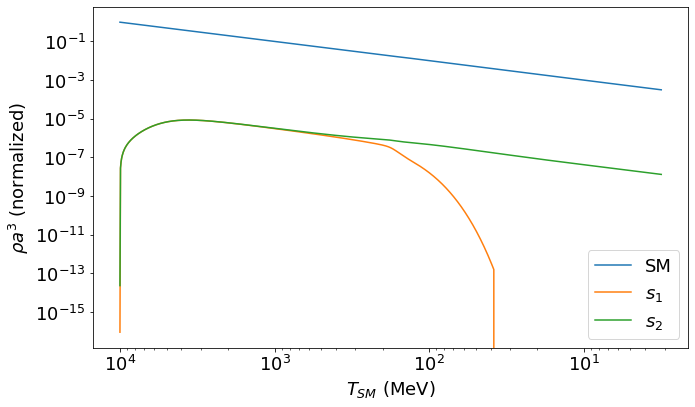

In [77]:
# import the data
with open('data/T_DS_results.pkl', 'rb') as file:
    data_dict = pickle.load(file)

# Get the single model parameters
ms1_idx, sinsq2theta_idx, ms2_idx = 6, 0, 0
ms1 = data_dict['ms1_values'][ms1_idx]
ms2 = data_dict['ms2_values'][ms2_idx]
sinsq2theta = data_dict['sinsq2theta_values'][sinsq2theta_idx]
print("ms1 = {} MeV, ms2 = {} MeV, sin^2(2theta) = {}".format(
    '{:.3g}'.format(ms1), '{:.3g}'.format(ms2), '{:.3g}'.format(sinsq2theta)))

# Get the dark sector energy density
T_DS = data_dict['T_DS_domain'][sinsq2theta_idx, ms1_idx, ms2_idx, :]
a_domain = data_dict['a_domain']
rho_s1 = 2*sm.compute_energy_density(T_DS, ms1, -1)*a_domain**3
rho_s2 = 2*sm.compute_energy_density(T_DS, ms2, -1)*a_domain**3

# get the SM energy density
T_SM = data_dict['T_SM_domain']
rho_sm = ds.energy_density_func(T_SM)*a_domain**3

# Plot
plt.figure(figsize=(10, 6))
plt.loglog(T_SM, rho_sm/rho_sm[0], label=r"SM")
plt.loglog(T_SM, rho_s1/rho_sm[0], label=r"$s_1$")
plt.loglog(T_SM, rho_s2/rho_sm[0], label=r"$s_2$")

plt.xlabel(r"$T_{SM}$ (MeV)")
plt.ylabel(r"$\rho a^3$ (normalized)")
plt.tight_layout()
plt.gca().invert_xaxis()
#plt.ylim(10**-7, 3)
plt.legend(fontsize=18)
plt.show()

# Contour Plots of Final Dark Sector Temperatures

Load the data

In [116]:
# Load a pickle file with the data
with open('data/T_DS_results.pkl', 'rb') as file:
    data_dict = pickle.load(file)

T_SM_final = data_dict['T_SM_domain'][-1]
T_DS_interp = interpolate.RegularGridInterpolator((data_dict['sinsq2theta_values'], data_dict['ms1_values']), 
                                                  data_dict['T_DS_domain'][:,:,0,-1], method='linear')
# Create a dense 2D grid of T_DS values, with dimensions (sinsq2theta, ms1)
num = 100
ms1_dense = np.logspace(np.log10(np.min(data_dict['ms1_values'])), np.log10(np.max(data_dict['ms1_values'])), num)
sinsq2theta_dense = np.logspace(np.log10(np.min(data_dict['sinsq2theta_values'])), np.log10(np.max(data_dict['sinsq2theta_values'])), num)
T_DS_dense = []
for ms1 in ms1_dense:
    for sinsq2theta in sinsq2theta_dense:
        T_DS_dense.append(T_DS_interp((sinsq2theta, ms1)))
# reshape the array
T_DS_dense = np.array(T_DS_dense).reshape((len(ms1_dense), len(sinsq2theta_dense)))

## $T_{DS}/T_{SM}$

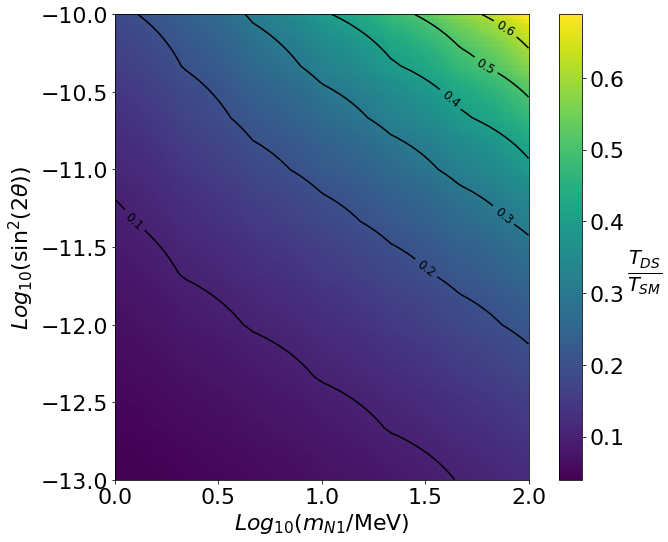

In [132]:
temp_ratio = T_DS_dense/T_SM_final

plt.figure(figsize=(8,8))
im = plt.imshow(temp_ratio.T, origin='lower',
                  extent=[np.log10(ms1_dense[0]), np.log10(ms1_dense[-1]),
                                np.log10(sinsq2theta_dense[0]), np.log10(sinsq2theta_dense[-1])])

X, Y = np.meshgrid(np.log10(ms1_dense), np.log10(sinsq2theta_dense))
contours = plt.contour(X, Y, temp_ratio.T, colors='k')  # 'k' means black
plt.clabel(contours, inline=True, fontsize=12)

plt.xlabel(r'$Log_{10}(m_{N1}$/MeV)')
plt.ylabel(r'$Log_{10}(\sin^2(2 \theta))$')

cb = plt.colorbar(im)
cb.set_label(r'$\frac{T_{DS}}{T_{SM}}$', rotation=0, labelpad=20, fontsize=28)
plt.gca().set_aspect(0.75)
# Make the colorbar size the same as the plot
plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.show()

## Required $m_{N2}$

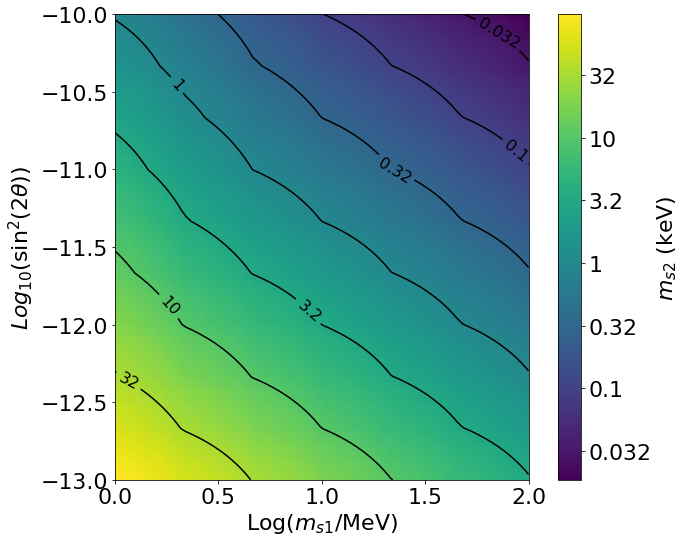

In [131]:
from matplotlib.ticker import FuncFormatter

ms2_required = [10**3*c.rho_crit_over_hsq*0.12/ds.compute_current_DM_ndens(T_SM_final, T_DS) for T_DS in T_DS_dense.flatten()]
ms2_required = np.array(ms2_required).reshape((len(ms1_dense), len(sinsq2theta_dense)))

plt.figure(figsize=(8,8))
im = plt.imshow(np.log10(ms2_required.T), origin='lower',
                    extent=[np.log10(ms1_dense[0]), np.log10(ms1_dense[-1]),
                                np.log10(sinsq2theta_dense[0]), np.log10(sinsq2theta_dense[-1])])

X, Y = np.meshgrid(np.log10(ms1_dense), np.log10(sinsq2theta_dense))
# Make all the contour lines solid
contours = plt.contour(X, Y, np.log10(ms2_required.T), colors='k', linestyles='solid')
# Put the contour labels as 10^x
def format_func(value, tick_number):
    return r'{:.2g}'.format(10**value)
plt.clabel(contours, inline=True, fontsize=16,  fmt=FuncFormatter(format_func))

cb = plt.colorbar(im)
cb.set_label(r'$m_{N2}$ (keV)')
# Put the colorbar labels as 10^x
cb.formatter = FuncFormatter(format_func)
cb.update_ticks()

plt.xlabel(r'Log($m_{N1}$/MeV)')
plt.ylabel(r'$Log_{10}(\sin^2(2 \theta))$')
plt.gca().set_aspect(0.75)
# Make the colorbar size the same as the plot
plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.show()

# Combined Active Neutrino Scattering Rate

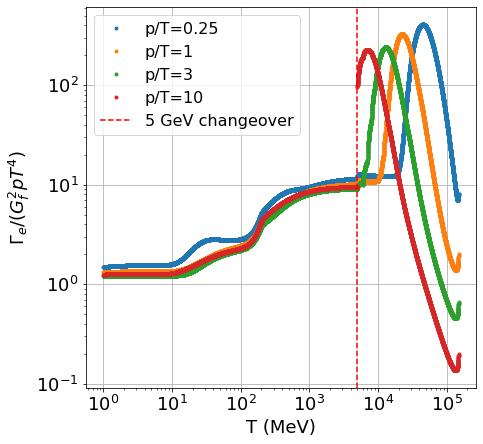

In [3]:
# Compare to fig. 6 in https://arxiv.org/pdf/1605.07720.pdf
T_domain = np.logspace(0, np.log10(149*10**3), 10**4)
flavor='electron'

plt.figure(figsize=(7,7))
for poverT in [0.25, 1, 3, 10]:
    p_domain = poverT*T_domain
    plt.loglog(T_domain, sid.active_scattering_rate(p_domain, T_domain, flavor)/(c.Gf**2*p_domain*T_domain**4),  '.', label='p/T={}'.format(poverT))
plt.ylabel(r"$\Gamma_e / (G_f^2 p T^4)$")
plt.xlabel("T (MeV)")
plt.axvline(5*10**3, c='r', ls='--', label="5 GeV changeover")
plt.grid()
plt.legend(fontsize=16)
plt.show()

